In [624]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal
from mne_icalabel import label_components
import os
# fastica, picard, infomax. Picard maybe better

In [946]:
# Select file from measurement
# Change next to lines if needed
path = "C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt/"
filename = "EEGdata-2024-144--14-56-37"
df = pd.read_csv(path+filename + ".csv", sep=",")
end = df.shape[0] # Remove 5 samples buffer at the end
fs = 250
df = df.iloc[:end, :8] # Select 72000 samples from 8 channels
df

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,232129.406250,246206.718750,241103.187500,236718.671875,222570.093750,228633.140625,219861.687500,210217.453125
1,232058.687500,246152.531250,241088.515625,236697.750000,222586.109375,228615.437500,219854.265625,210206.718750
2,232031.328125,246109.343750,241085.656250,236672.000000,222457.796875,228584.062500,219788.734375,210163.093750
3,232066.468750,246123.031250,241090.312500,236666.718750,222346.406250,228573.328125,219744.484375,210136.531250
4,232110.625000,246166.484375,241104.609375,236692.734375,222378.234375,228605.421875,219775.140625,210159.062500
...,...,...,...,...,...,...,...,...
72000,232473.984375,246332.687500,240768.625000,236487.187500,221664.500000,228988.000000,219161.093750,209661.078125
72001,232542.109375,246399.390625,240786.859375,236518.843750,221755.062500,229022.250000,219199.187500,209688.781250
72002,232544.343750,246418.421875,240794.281250,236536.812500,221892.656250,229038.781250,219255.328125,209719.984375
72003,232442.156250,246328.843750,240766.296875,236497.828125,221836.609375,228999.984375,219223.062500,209690.750000


In [947]:
def filter(data):
    data = signal.detrend(data, axis = 0)

    # Define the filter parameters
    lowcut = 0.5
    highcut = 38
    fs = 250  # Sampling frequency

    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band')

    # Apply the filter to each column of the DataFrame
    df_filt = lfilter(b, a, data, axis = 0)

    # Define the filter parameters
    lowcut = 48
    highcut = 52
    fs = 250  # Sampling frequency

    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='bandstop')

    # Apply the filter to each column of the DataFrame
    df_filt1 = lfilter(b, a, df_filt, axis = 0)
    
    return df_filt1

In [948]:
#Apply the filters and DC component removal
df = filter(df)

In [949]:
# Constants
num_components = 8
allOutputs = df

channels = df.T

# create mne_info object
ch_names =        ['Fz', 
            'C3',  'Cz',  'C4', 
                   'Pz', 
            'PO7', 'Oz',  'PO8']

ch_type = ['eeg' for i in range(8)]
mne_info = mne.create_info(ch_names, float(250), ch_types=ch_type)

#create mne.raw object
raw = mne.io.RawArray(channels, mne_info)
raw.set_montage(mne.channels.make_standard_montage("standard_1005"))

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [950]:
#actual code
raw.filter(0.5, 38)

# ICA model
ica = mne.preprocessing.ICA(method='picard', fit_params=dict(ortho=False,extended=True), n_components=num_components, random_state=0)
#ica = mne.preprocessing.ICA(method='infomax', fit_params=dict(extended=True), n_components=num_components, random_state=0)
ica.fit(raw) # fit the model on the data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 1651 samples (6.604 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 6.8s.


Method,picard
Fit parameters,ortho=Falseextended=Truemax_iter=500
Fit,66 iterations on raw data (72005 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


In [951]:
# # assuming you have a Raw and ICA instance previously fitted
# labels = label_components(raw, ica, method='iclabel')

# # Find the channels which have a probability of less than 0.9
# print("Potential bad channels: /n",np.where(labels['y_pred_proba'][labels['y_pred_proba'] < 0.80])[0])

Creating RawArray with float64 data, n_channels=8, n_times=72005
    Range : 0 ... 72004 =      0.000 ...   288.016 secs
Ready.


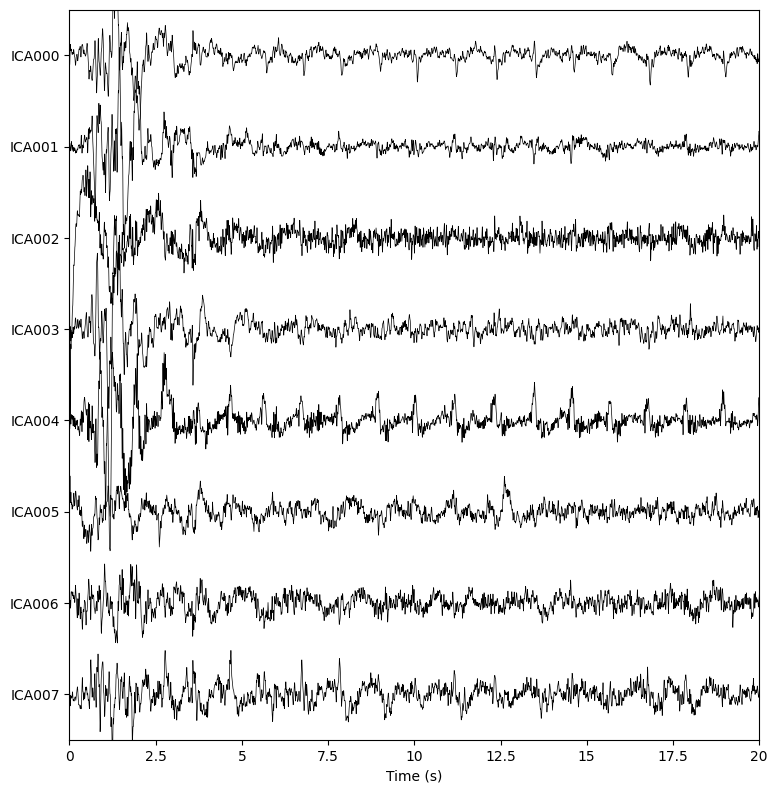

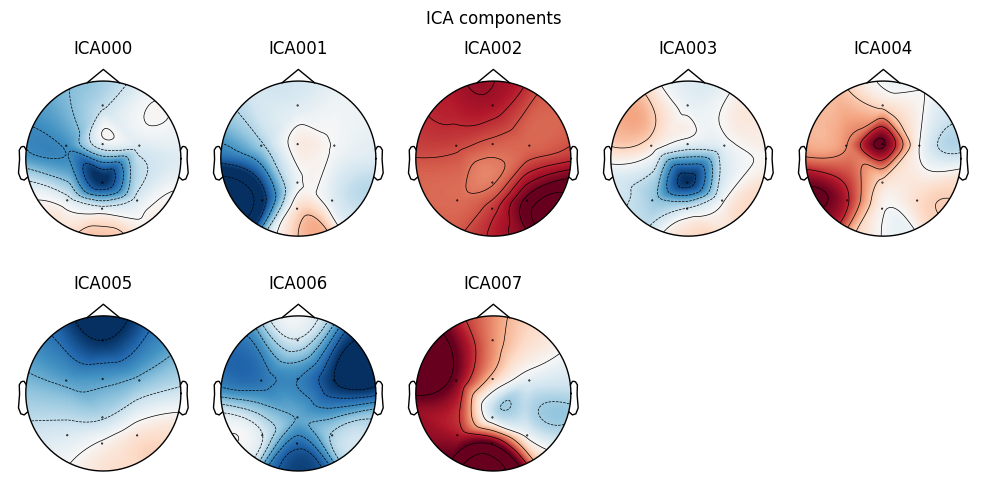

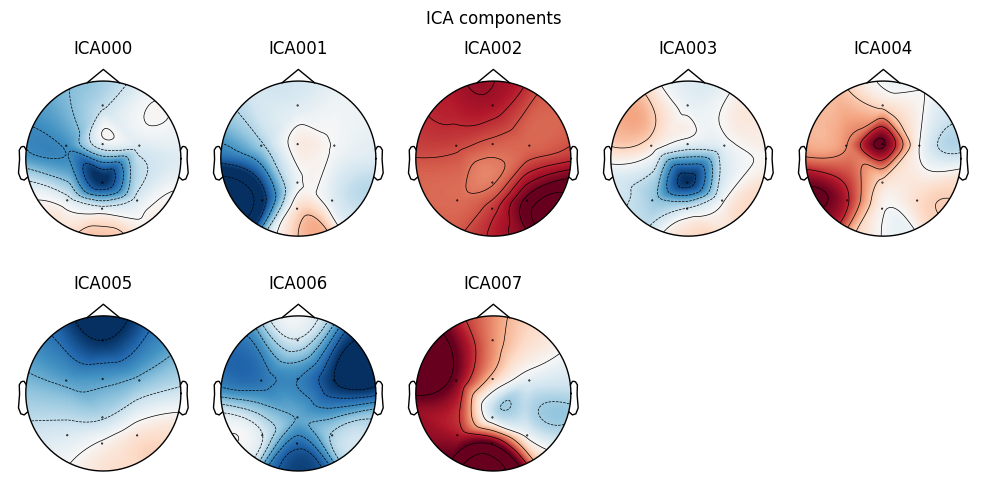

In [952]:
# Plot the raw data channels and also the ICA signal components
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)
ica.plot_components(picks=range(num_components), ch_type='eeg')


In [953]:
# # ICA plot overlay to see difference when excluding
# ica.plot_overlay(raw, exclude=[0,1], picks="eeg")

In [954]:
#ica.plot_properties(raw, picks=[0, 1])

In [985]:
bad_channels_l = []
i = 0

# Cycle through exclude indices from 0 to 7
for exclude_index in range(8):
    dif_l1 = []
    # Change the indices which needs to be removed based on the plots and bad channels
    ica.exclude = [exclude_index]  # indices chosen based on various plots above

    # ica.apply() changes the Raw object in-place, so let's make a copy first:
    reconst_raw = raw.copy()
    ica.apply(reconst_raw)

    # Transpose to recreate the original shape
    raw_array = raw[:][0].T
    reconst_raw_array = reconst_raw[:][0].T

    for channel in range(8):
        # assign raw and reconstructed signal to variables
        signal1 = raw_array[:,channel]
        signal2 = reconst_raw_array[:,channel]

        # calculate the minimum and maximum of both signals to determine peaks
        max1 = np.max(signal1)
        max2 = np.max(signal2)
        min1 = np.min(signal1)
        min2 = np.min(signal2)

        vars = np.std(signal2) * 8
        vars1 = np.std(signal1)
        vars2 = np.std(signal2)

        # Calculate the difference betweeen man and min of both signals
        dif1 = max1 - min1
        dif2 = max2 - min2

        # Append to list
        dif_l1.append(dif2)

        print(vars2)

        if np.abs(dif1-dif2) > vars and vars2 > 6:
            bad_channels_l.append(i)

        #print(dif2)

        # bad_channels = [i for i, value in enumerate(dif_l1) if value > vars]
        # if len(bad_channels) > 0:
        #     bad_channels_l.append(i)
    
    # # plot the original and ICA filtered signal
    # x1 = np.linspace(0, end/fs, end, endpoint=True)

    # fig, axs = plt.subplots(8, figsize=(10 , 5))
    # fig.suptitle(f'EEG signals channel {exclude_index} excluded')
    # for i in range(8):
    #     # axs[i].plot(x1[1000:],raw_array[1000:,i])
    #     # axs[i].plot(x1[1000:],reconst_raw_array[1000:,i])
    #     axs[i].plot(x1[:],raw_array[:,i])
    #     axs[i].plot(x1[:],reconst_raw_array[:,i])
    #     axs[i].set_xlabel('Time (seconds)')
    #     axs[i].set_ylabel(f'Channel {i+1}')

    # plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    # plt.show()

    i += 1
    
print(bad_channels_l)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
9.755070345527821
9.785404598851636
10.443136665883076
6.843186617607656
11.571994093094798
15.665441464149529
7.755718619196094
7.423994320319181
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
10.181213351508651
11.922126951337042
10.430028358015017
7.074371532041637
17.777899835486938
8.98008629130432
7.712135924303506
7.539512538655635
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
8.527241584675766
11.646633616843987
9.641560446895216
5.796078112336488
17.421936454492144
15.270981616199489
6.307715327410526
3.2272133524424698
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    P

In [986]:
# Change the indices which needs to be removed based on the plots and bad channels
ica.exclude = bad_channels_l  # indices chosen based on various plots above

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 4 ICA components
    Projecting back using 8 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.50 Hz
Lowpass,38.00 Hz


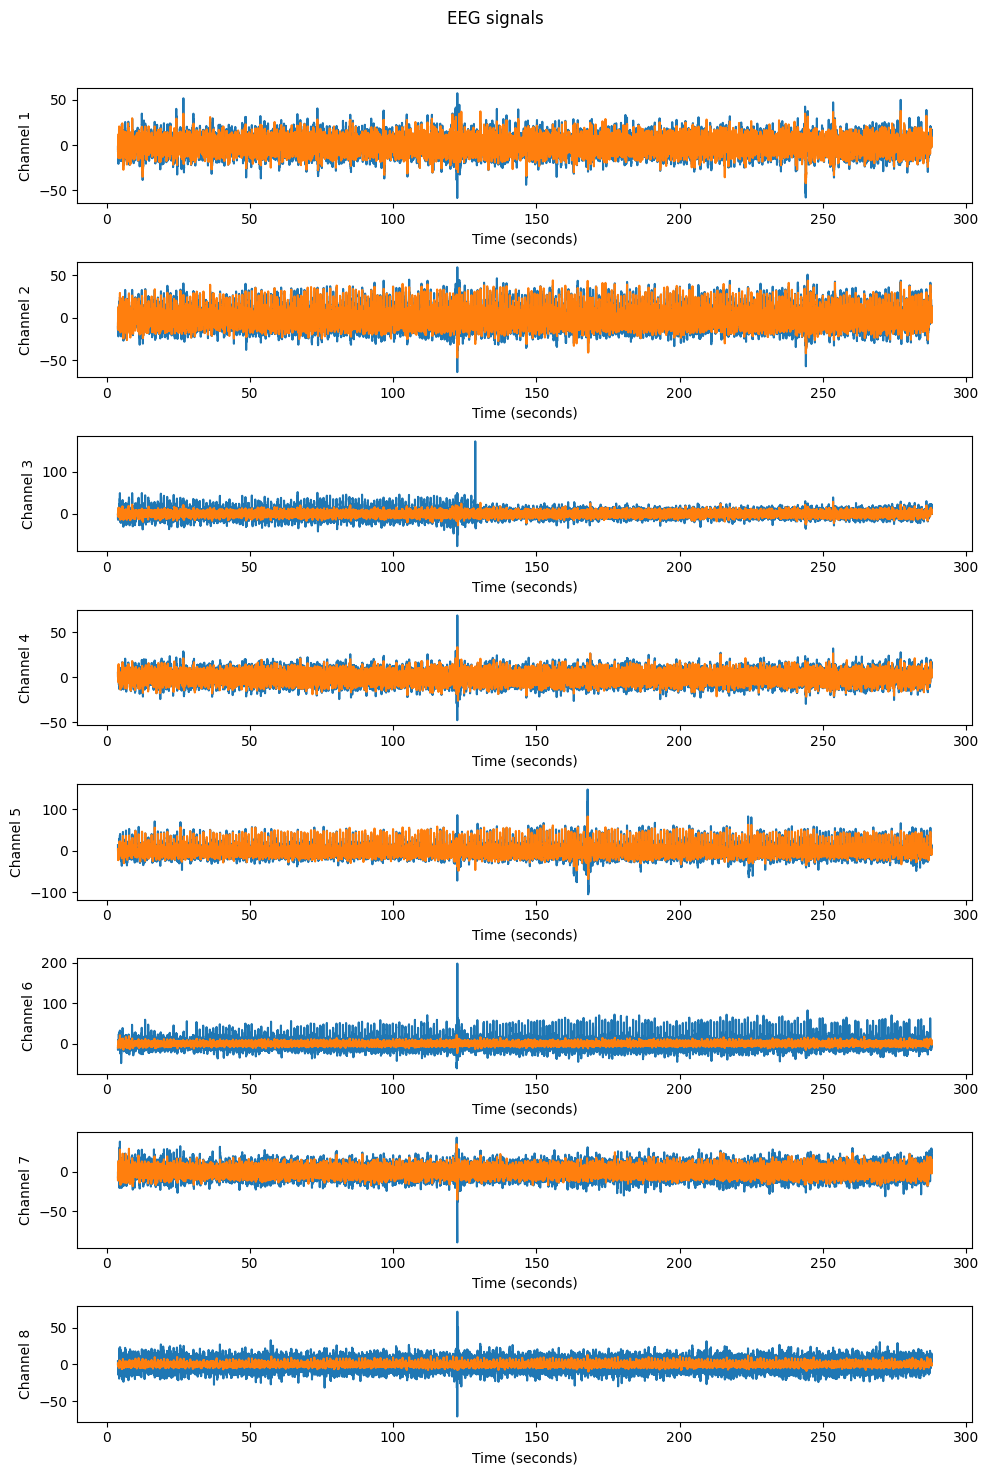

In [987]:
# Transpose to recreate the original shape
raw_array = raw[:][0].T
reconst_raw_array = reconst_raw[:][0].T

# plot the original and ICA filtered signal
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1[1000:],raw_array[1000:,i])
    axs[i].plot(x1[1000:],reconst_raw_array[1000:,i])
    # axs[i].plot(x1[:],raw_array[:,i])
    # axs[i].plot(x1[:],reconst_raw_array[:,i])
    axs[i].set_xlabel('Time (seconds)')
    axs[i].set_ylabel(f'Channel {i+1}')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()

In [988]:
# Convert ICA signal to csv file and add columns which were removed before ICA
ICA_data = pd.DataFrame(reconst_raw_array)

# Add columns that were removed
df = pd.read_csv(path+filename + ".csv", sep=",")
columns_add = df[['Counter', 'Validation', 'Label']] # select the last three columns to be added

# Rename the columns of df2 to correspond to the first 8 columns of df1
ICA_data.columns = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']

# Adding the last three columns to ICA_data
ICA_data = pd.concat([ICA_data, columns_add], axis=1)


#ICA_data.to_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt_ICA/" +filename + "_ICA.csv", index = False)

In [989]:
ICA_data

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8,Counter,Validation,Label
0,0.011535,0.007982,0.019682,0.008346,0.011485,-0.001292,0.013939,0.014231,154968.0,1.0,0
1,-2.442248,6.107051,-1.578108,-0.796153,9.377913,2.584265,4.770346,2.605339,154969.0,1.0,0
2,-10.484068,5.245972,-6.461474,-4.275894,13.154120,2.464780,6.588436,4.847017,154970.0,1.0,0
3,-23.894231,-4.391275,-14.454104,-10.410330,8.793679,-1.093352,4.240298,6.119401,154971.0,1.0,0
4,-36.230451,-18.213973,-21.641486,-16.185447,-1.860567,-6.352073,-1.049716,5.792566,154972.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
72000,3.689622,0.629370,5.552238,5.263729,-8.422108,1.367905,3.823141,-0.921607,226968.0,1.0,0
72001,6.274440,4.501743,6.860412,5.762286,-6.355841,3.515940,6.198094,-0.865609,226969.0,1.0,0
72002,6.842281,5.919477,6.435205,5.034274,-3.951610,4.068408,6.268922,-0.733459,226970.0,1.0,0
72003,4.486940,4.088793,3.927319,2.957093,-1.793823,2.680487,3.898154,-0.431413,226971.0,1.0,0
